# Web Scraping Assignment
by Hannah, Hoda, Faluke

# 1. Libraries

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
import datetime as dt

# 2. Dataset

The dataset is from [goodreads]('https://www.goodreads.com') website. Using web scraping we can obtain the following dataframe.

In [ ]:
url='https://www.goodreads.com/search?q=Kahlil+Gibran&search%5Bsource%5D=goodreads&search_type=books&tab=books'
response=requests.get(url)
response_j=response.content.decode("utf-8")
parser = BeautifulSoup(response_j, 'html.parser')
info_lists=[]
info=parser.find_all('td',valign="top", width="100%")
for i in range(0,len(info)):
    info_lists.append(info[i].text)
for items in range(0,len(info_lists)):
    match = re.findall(r'\w.+', info_lists[items])
    for i in range(0,len(match[3])):
        if match[3][i]=='—':
            av_rat=match[3][0:i]
            rat_count=match[3][i+1:].strip()
    for i in range(0,len(av_rat)):
        if av_rat[i] == ' ':
            av_rat_num=float(av_rat[0:i])
            av_rat_str=av_rat[i+1:]
            break
    for i in range(0,len(rat_count)):
        if rat_count[i] == ' ':
            rat_count_num=rat_count[0:i]
            rat_count_str=rat_count[i+1:]
            break
    edition_str=match[6]
    for i in range(0,len(edition_str)):
        if edition_str[i] == ' ':
            edition_str_num=edition_str[0:i]
            break
    if match[5].isnumeric() == True:
        year_published = match[5]
    else:
        year_published = match[6]
    info_dict={'books_count':edition_str_num,rat_count_str:rat_count_num\
               ,'publication_year':year_published,av_rat_str:av_rat_num\
               ,'title':match[0]\
               ,'author_name':match[2]}
    if items == 0:
        df=pd.DataFrame([info_dict])
    else:
        df=pd.concat([df,pd.DataFrame([info_dict])],ignore_index=True)
df.head()

,books_count,ratings,publication_year,avg rating,title,author_name
0,200,"227,075",1923,4.23,The Prophet,Kahlil Gibran
1,41,"1,949",1947,4.42,The Treasured Writings of Kahlil Gibran,Kahlil Gibran
2,41,"1,949",1972,4.42,نامه‌های عاشقانه‌ی یک پیامبر,"Kahlil Gibran,"
3,41,"1,949",1964,4.42,المجموعة الكاملة لمؤلفات جبران خليل جبران,"Kahlil Gibran,"
4,41,"1,949",1912,4.42,The Broken Wings,"Kahlil Gibran,"


However, the same dataframe can be formed by using an API offered by goodsread. The requested results returns a xml file (which is more straighforward), and also make sure the permission issues. 

The following request use a key word, represented by "q":"key_word" to get data. 
- The results contains key_word either in the title or in the author. 
- A total of 20 books searched in each request (for each page).



In [ ]:
df.head(2)

,books_count,ratings,publication_year,avg rating,title,author_name
0,200,"227,075",1923,4.23,The Prophet,Kahlil Gibran
1,41,"1,949",1947,4.42,The Treasured Writings of Kahlil Gibran,Kahlil Gibran


In [ ]:
#generating the same DataFrame using the API
authors = ['Kahlil Gibran', 'J.D. Salinger', 'J.K. Rowling', 'Franz Kafka', 'Ernest Hemingway']
q_count = 1
for q in authors:
    for page in range(1,11):
        respons = requests.get("https://www.goodreads.com/search/index.xml", \
                               params={"key": "Mk6YbRkCGRlliFxyxhV2iQ","format":"json", "q":q,'page':page\
                                       ,'search':'author'})
        respons_j = respons.content.decode("utf-8")
        parser = BeautifulSoup(respons_j, 'html.parser')
        results = parser.find_all('work')
        for i in range(0,len(results)):
            my_dict = {'id':results[i].id.text,'books_count':results[i].books_count.text\
                    ,'ratings_count':results[i].ratings_count.text\
                    ,'text_reviews_count':results[i].text_reviews_count.text\
                    ,'original_publication_year':results[i].original_publication_year.text\
                    ,'original_publication_month':results[i].original_publication_month.text\
                    ,'original_publication_day':results[i].original_publication_day.text\
                    ,'average_rating':results[i].average_rating.text,'title':results[i].best_book.title.text\
                    ,'author_id':results[i].best_book.author.id.text\
                    ,'author_name':results[i].best_book.author.find_all('name')[0].text\
                    ,'image_url':results[i].best_book.image_url.text}
            if i == 0:
                my_df = pd.DataFrame([my_dict])
            else:
                my_df = pd.concat([my_df,pd.DataFrame([my_dict])],ignore_index=True)
        if q_count == 1:
            if page == 1:
                a_df = my_df.copy()
            else:
                a_df = pd.concat([a_df,my_df],ignore_index=True)
        else:
            a_df = pd.concat([a_df,my_df],ignore_index=True)
        q_count += 1

In [ ]:
a_df.head()

,id,books_count,ratings_count,text_reviews_count,original_publication_year,original_publication_month,original_publication_day,average_rating,title,author_id,author_name,image_url
0,2938937,200,227075,9210,1923,,,4.23,The Prophet,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
1,6518,41,1949,75,1947,,,4.42,The Treasured Writings of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
2,1978274,51,3144,432,1972,2,12,3.69,نامه‌های عاشقانه‌ی یک پیامبر,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...
3,45780596,25,1682,95,1964,,,4.45,المجموعة الكاملة لمؤلفات جبران خليل جبران,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
4,1676536,213,16503,1994,1912,,,3.93,The Broken Wings,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...


Meaning of some of the columns:
- 'books_count' means number of editions available on goodreads website, like kindle eidtion, hardcover, paperback, audiobook and so on.
- 'ratings_count' means the number of ratings
- 'text_reviews_count' means the number of reviews

In [ ]:
a_df['author_name'].value_counts()

Kahlil Gibran              163
Franz Kafka                123
Ernest Hemingway            95
J.D. Salinger               66
J.K. Rowling                60
                          ... 
John Kessel                  1
David Sandison               1
Timothy Taaffe               1
McKenna Schmidt Shannon      1
Freedom Puzzles              1
Name: author_name, Length: 396, dtype: int64

# 3. Data cleaning

## 3.1 Collect authors

In [ ]:
a_df=a_df.drop_duplicates()
df=a_df[(a_df['author_name']=='Kahlil Gibran') | (a_df['author_name']=='J.D. Salinger')\
     | (a_df['author_name']=='J.K. Rowling') | (a_df['author_name']=='Franz Kafka') \
     | (a_df['author_name']=='Ernest Hemingway')]

## 3.2 Collect english books

In [ ]:
def save_eng(string):
    if re.findall(r'[a-zA-Z0-9].*',string) != []:
        if string == re.findall(r'[a-zA-Z0-9].*',string)[0]:
            return True

In [ ]:
df_eng=df[df['title'].apply(save_eng)==True].reset_index()
df_eng.head()

,index,id,books_count,ratings_count,text_reviews_count,original_publication_year,original_publication_month,original_publication_day,average_rating,title,author_id,author_name,image_url
0,0,2938937,200,227096,9211,1923,,,4.23,The Prophet,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
1,1,6518,41,1949,75,1947,,,4.42,The Treasured Writings of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
2,4,1676536,213,16504,1994,1912,,,3.93,The Broken Wings,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...
3,5,78543265,4,424,31,,,,3.72,Love Letters: The Love Letters of Kahlil Gibra...,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
4,6,111402,3,145,9,2005,,,4.45,The Essential Kahlil Gibran,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...


## 3.3 Drop unnecessary columns
The publication months and days are not available for each book, we can also drop those.

In [ ]:
df_eng_year=df_eng.drop(['original_publication_month','original_publication_day','index'],axis=1)
df_eng_year.head()

,id,books_count,ratings_count,text_reviews_count,original_publication_year,average_rating,title,author_id,author_name,image_url
0,2938937,200,227096,9211,1923,4.23,The Prophet,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
1,6518,41,1949,75,1947,4.42,The Treasured Writings of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
2,1676536,213,16504,1994,1912,3.93,The Broken Wings,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...
3,78543265,4,424,31,,3.72,Love Letters: The Love Letters of Kahlil Gibra...,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
4,111402,3,145,9,2005,4.45,The Essential Kahlil Gibran,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...


## 3.4 Rename column names and type of the columns

In [ ]:
df_final=df_eng_year.rename({'books_count':'editions','original_publication_year':'year'\
                    ,'average_rating':'avg_rating'},axis=1)
df_final['id']=df_final['id'].astype(int)
df_final['editions']=df_final['editions'].astype(int)
df_final['ratings_count']=df_final['ratings_count'].astype(int)
df_final['text_reviews_count']=df_final['text_reviews_count'].astype(int)
df_final['avg_rating']=df_final['avg_rating'].astype(float)
df_final['author_id']=df_final['author_id'].astype(int)
df_final.head()

,id,editions,ratings_count,text_reviews_count,year,avg_rating,title,author_id,author_name,image_url
0,2938937,200,227096,9211,1923,4.23,The Prophet,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
1,6518,41,1949,75,1947,4.42,The Treasured Writings of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
2,1676536,213,16504,1994,1912,3.93,The Broken Wings,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...
3,78543265,4,424,31,,3.72,Love Letters: The Love Letters of Kahlil Gibra...,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
4,111402,3,145,9,2005,4.45,The Essential Kahlil Gibran,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...


## 3.5 The year column

The published years of some books are not available, these books are as follows:

In [ ]:
df_final[df_final['year']=='']

,id,editions,ratings_count,text_reviews_count,year,avg_rating,title,author_id,author_name,image_url
3,78543265,4,424,31,,3.72,Love Letters: The Love Letters of Kahlil Gibra...,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
18,58544333,5,92,8,,3.91,Kahlil Gibran's Little Book of Life,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
20,53946709,3,23,5,,4.52,A Treasury of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
22,43860963,3,17,2,,4.06,The Greatest Works of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
23,59237374,3,48,4,,4.58,Collected Works of Kahlil Gibran,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...
...,...,...,...,...,...,...,...,...,...,...
385,24075034,2,220,28,,3.22,My Old Man,1455,Ernest Hemingway,https://i.gr-assets.com/images/S/compressed.ph...
390,16610420,1,4,1,,3.25,Ernest Hemingway Collection: The Essential Hem...,1455,Ernest Hemingway,https://s.gr-assets.com/assets/nophoto/book/11...
399,24579046,1,2,0,,4.00,Ernest Hemingway selección,1455,Ernest Hemingway,https://s.gr-assets.com/assets/nophoto/book/11...
400,71158438,1,60,1,,4.25,For Whom the Bell Tolls Part 1,1455,Ernest Hemingway,https://s.gr-assets.com/assets/nophoto/book/11...


We can see that these books are collection of the works of the authors, but collected by other people. The collected date could be quite recent. We first denote it as not applicable.

In [ ]:
df_final['year']=df_final['year'].replace('','Not specified')
df_final.head()

,id,editions,ratings_count,text_reviews_count,year,avg_rating,title,author_id,author_name,image_url
0,2938937,200,227096,9211,1923,4.23,The Prophet,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
1,6518,41,1949,75,1947,4.42,The Treasured Writings of Kahlil Gibran,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
2,1676536,213,16504,1994,1912,3.93,The Broken Wings,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...
3,78543265,4,424,31,Not specified,3.72,Love Letters: The Love Letters of Kahlil Gibra...,6466154,Kahlil Gibran,https://i.gr-assets.com/images/S/compressed.ph...
4,111402,3,145,9,2005,4.45,The Essential Kahlil Gibran,6466154,Kahlil Gibran,https://s.gr-assets.com/assets/nophoto/book/11...


For the further cleaning, let us remove the above mentioned rows.

In [ ]:
df_clean=df_final.drop(labels=df_final[df_final['year']=='Not specified'].index).reset_index().drop('index',axis=1)
df_clean['year']=df_clean['year'].astype(int)

In [ ]:
df_clean = df_clean[['id', 'title', 'author_name', 'author_id', 'editions', 'year', 'avg_rating', 'ratings_count', 'text_reviews_count', 'image_url']]

## 3.6 Author ages

We can use web scraping again to obtain the authors' birth date and the their age when they ceated their works.

In [ ]:
author_date={}
authors = ['Kahlil Gibran', 'J.D. Salinger', 'J.K. Rowling', 'Franz Kafka', 'Ernest Hemingway']
urls=['https://www.goodreads.com/author/show/6466154.Kahlil_Gibran'\
      ,'https://www.goodreads.com/author/show/819789.J_D_Salinger?from_search=true&from_srp=true'\
     ,'https://www.goodreads.com/author/show/1077326.J_K_Rowling?from_search=true&from_srp=true'\
     ,'https://www.goodreads.com/author/show/5223.Franz_Kafka'\
     ,'https://www.goodreads.com/author/show/1455.Ernest_Hemingway']

for i in range(0,len(urls)):
    url=urls[i]
    respons=requests.get(url)
    respons_j=respons.content.decode("utf-8")
    parser = BeautifulSoup(respons_j, 'html.parser')
    #born_date=dt.datetime.strptime(parser.find_all('div', class_="dataItem")[0].text.replace('\n','').strip(),"%B %d, %Y").year
    #death_date=dt.datetime.strptime(parser.find_all('div', class_="dataItem")[1].text.replace('\n','').strip(),"%B %d, %Y").year
    born_date=parser.find_all('div', class_="dataItem")[0].text.replace('\n','').strip()
    #death_date=parser.find_all('div', class_="dataItem")[1].text.replace('\n','').strip()
   
    
    data_titles=parser.find_all('div', class_="dataTitle")
    death_date_index=-1
    for index, data_title in enumerate(data_titles):
        if 'died' in data_title.text.lower():
            death_date_index = index
            break
            
    
    genre_index=-1
    for index, data_title in enumerate(data_titles):
        if 'genre' in data_title.text.lower():
            genre_index = index
            break
    genre=parser.find_all('div', class_="dataItem")[genre_index].text.replace('\n','').strip()
    author_date['author']=authors[i]
    author_date['born_date']=born_date
    if death_date_index == -1:
        author_date['death_date']='-'
    else:
        death_date=parser.find_all('div', class_="dataItem")[death_date_index].text.replace('\n','').strip()
        author_date['death_date']=death_date
    author_date['genre']=genre
    if i==0:
        author_df=pd.DataFrame([author_date])
    else:
        author_df=pd.concat([author_df,pd.DataFrame([author_date])],ignore_index=True)

In [ ]:
author_df

,author,born_date,death_date,genre
0,Kahlil Gibran,"January 06, 1883","April 10, 1931","Philosophy, Poetry, Spirituality"
1,J.D. Salinger,"January 01, 1919","January 27, 2010","Literature & Fiction, Short Stories"
2,J.K. Rowling,"July 31, 1965",-,"Fiction, Young Adult, Fantasy"
3,Franz Kafka,"July 03, 1883","June 03, 1924","Fiction, Philosophy, Short Stories"
4,Ernest Hemingway,"July 21, 1899","July 02, 1961",Fiction


In [ ]:
def author_date(string):
    return dt.datetime.strptime(string,"%B %d, %Y").year
def add_birth_date(string):
    return author_df[author_df['author']==string]['born_date'].iloc[0]
def add_genre(string):
    return author_df[author_df['author']==string]['genre'].iloc[0]

In [ ]:
author_df['born_date']=author_df['born_date'].apply(author_date)
df_clean['birth_date']=df_clean['author_name'].apply(add_birth_date)
df_clean['work_age']=df_clean['year']-df_clean['birth_date']
df_clean['genre']=df_clean['author_name'].apply(add_genre)

In [ ]:
df_clean['work_age'].unique()

array([ 40,  64,  29, 122, 127,  79,  88,  43,  35, 112,  77, 133, 114,
        31,  45,  91,  48,  49, 116,  75, 129, 125,  82, 111,  94, 108,
       136, 121, 119, 124, 130, 118, 131, 126,  51, 115, 128,  76,  89,
        97,  98,  93,  92,  99,  95, 132,  32,  42,  34,  36,  21,  46,
        55,  30, 141,  33,  72,  22,  25,  26,  50,  27,  23,  24,  70,
        71,  38,  47,  53,  52,  39,  63,  44,  41,  69,  66,  65,  96,
       106,  84,  78,  73, 104, 123, 110,  81,  37,  87,  85,  62,  28,
        67,  86, 100, 102, 109, 101,  80, 113,  68, 103,  54])

Most of the authors died long before 100 year old, so the books with these ages are also actually collected by other people, these should be removed as well.

In [ ]:
df_clean=df_clean.drop(labels=df_clean[(df_clean['author_name']=='Kahlil Gibran') & (df_clean['work_age']>48)].index)
df_clean=df_clean.drop(labels=df_clean[(df_clean['author_name']=='J.D. Salinger') & (df_clean['work_age']>91)].index)
df_clean=df_clean.drop(labels=df_clean[(df_clean['author_name']=='Franz Kafka') & (df_clean['work_age']>41)].index)
df_clean=df_clean.drop(labels=df_clean[(df_clean['author_name']=='Ernest Hemingway') & (df_clean['work_age']>62)].index)
df_clean=df_clean.reset_index().drop(columns='index')

In [ ]:
df_clean

,id,title,author_name,author_id,editions,year,avg_rating,ratings_count,text_reviews_count,image_url,birth_date,work_age,genre
0,2938937,The Prophet,Kahlil Gibran,6466154,200,1923,4.23,227096,9211,https://i.gr-assets.com/images/S/compressed.ph...,1883,40,"Philosophy, Poetry, Spirituality"
1,1676536,The Broken Wings,Kahlil Gibran,6466154,213,1912,3.93,16504,1994,https://s.gr-assets.com/assets/nophoto/book/11...,1883,29,"Philosophy, Poetry, Spirituality"
2,2779610,Sand and Foam,Kahlil Gibran,6466154,116,1926,4.07,5581,613,https://s.gr-assets.com/assets/nophoto/book/11...,1883,43,"Philosophy, Poetry, Spirituality"
3,6517,The Madman,Kahlil Gibran,6466154,267,1918,4.07,7620,681,https://s.gr-assets.com/assets/nophoto/book/11...,1883,35,"Philosophy, Poetry, Spirituality"
4,1826005,A Tear and a Smile,Kahlil Gibran,6466154,164,1914,4.00,4530,361,https://i.gr-assets.com/images/S/compressed.ph...,1883,31,"Philosophy, Poetry, Spirituality"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,3988386,The End of Something,Ernest Hemingway,1455,3,1925,3.45,216,13,https://s.gr-assets.com/assets/nophoto/book/11...,1899,26,Fiction
137,3970824,The Hemingway Reader,Ernest Hemingway,1455,8,1953,4.06,49,8,https://s.gr-assets.com/assets/nophoto/book/11...,1899,54,Fiction
138,41095645,Cuentos,Ernest Hemingway,1455,9,1938,4.00,221,18,https://i.gr-assets.com/images/S/compressed.ph...,1899,39,Fiction
139,26344204,The Three Days Blow,Ernest Hemingway,1455,3,1925,3.12,175,23,https://s.gr-assets.com/assets/nophoto/book/11...,1899,26,Fiction


# 4. Data analysis

In [ ]:
# Import visualization library
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px


# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import plotly.graph_objs as go
# import chart_studio.plotly as py

init_notebook_mode(connected=True)
cf.go_offline(connected=True)

# Set global theme
cf.set_config_file(world_readable=True, theme='pearl')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 4.1 Best Books

Three highest rating books for each author. Do you enjoy reading? Try these.

In [ ]:
df_clean.loc[df_clean.groupby(['author_name'])['avg_rating'].nlargest(n=3).to_frame().reset_index().level_1]\
.reset_index(drop=True)[['author_name','title','avg_rating','year','work_age']]

,author_name,title,avg_rating,year,work_age
0,Ernest Hemingway,The Complete Short Stories of Ernest Hemingway,4.29,1925,26
1,Ernest Hemingway,A Clean Well Lighted Place,4.15,1926,27
2,Ernest Hemingway,The Hemingway Reader,4.06,1953,54
3,Franz Kafka,A Hunger Artist,4.13,1924,41
4,Franz Kafka,"The Metamorphosis, In the Penal Colony, and Ot...",4.05,1915,32
5,Franz Kafka,The Metamorphosis and Other Stories,4.03,1915,32
6,J.D. Salinger,The Heart of a Broken Story,4.43,1941,22
7,J.D. Salinger,Teddy,4.42,1953,34
8,J.D. Salinger,A Perfect Day for Bananafish,4.33,1948,29
9,J.K. Rowling,Harry Potter Illustrated Box Set (Harry Potter...,4.79,2016,51


## 4.2 Ages distribution

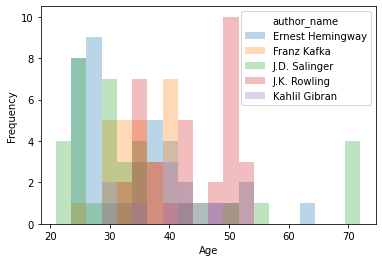

In [ ]:
ax=df_clean[['author_name','work_age']].pivot(columns='author_name',values='work_age')\
.plot(kind='hist', alpha=0.3,bins=20)
ax.set_xlabel("Age");

In [ ]:
df_clean.groupby('author_name')['work_age'].describe()

,count,mean,std,min,25%,50%,75%,max
author_name,,,,,,,,
Ernest Hemingway,38.0,34.684211,9.467170,24.0,27.0,33.5,39.0,62.0
Franz Kafka,26.0,34.576923,4.319010,26.0,32.0,35.0,38.5,41.0
J.D. Salinger,35.0,35.400000,15.047376,21.0,26.0,30.0,36.0,72.0
J.K. Rowling,33.0,43.545455,7.233131,32.0,36.0,43.0,51.0,53.0
Kahlil Gibran,9.0,39.000000,6.284903,29.0,35.0,40.0,43.0,48.0


Observations: 
- Among the books within the data set, J.D.Salinger published his book with youngest age at 21 years old while J.K.Rowling has her first book at the age of 32.  
- The writer had his book published at the oldest age is J.D.Salinger at 72 years old while Kafka has his last book at the age of 41
- 3 among 5 authors published 75% of their works when they were under 40 years old.

## 4.3 Average rate versus authors ages

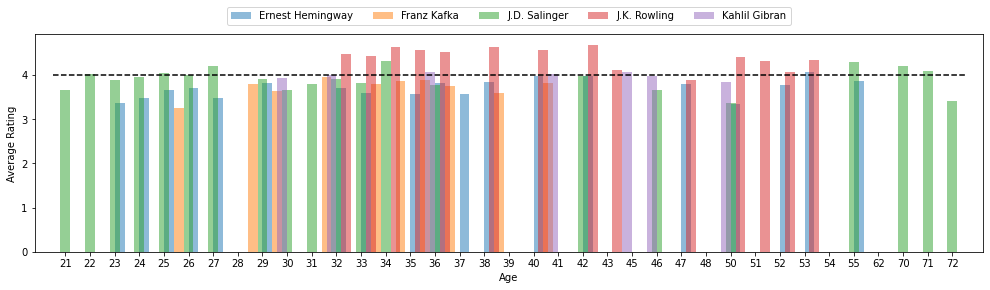

In [ ]:
# Work age vs average rate
ax=df_clean.groupby(['author_name','work_age']).avg_rating.mean().to_frame().reset_index()\
.pivot(index='work_age',columns='author_name',values='avg_rating').plot(kind='bar',figsize=(17,4),width=2,alpha=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=5)
ax.set_xticklabels(df_clean.groupby(['author_name','work_age']).avg_rating.mean().to_frame().reset_index()\
.pivot(index='work_age',columns='author_name',values='avg_rating').index, rotation=0);
ax.set(xlabel='Age',ylabel="Average Rating");
ax.hlines(4, -.5,36.5, linestyles='dashed');

Observation: 
- Some authors best works appeared during some ages, like J. K. Rowling's best works appeared around 40s.
- Some authors best works evenly distributed their life, like J. D. Salinger.

## 4.4 Authors average ratings and genre

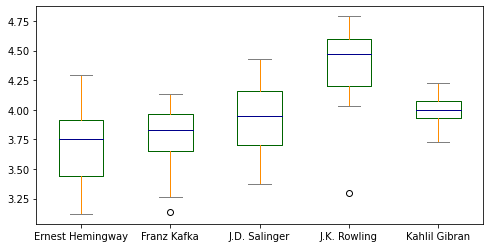

In [ ]:
df_clean.pivot(columns='author_name',values='avg_rating').plot(kind='box',figsize=(8,4)\
      ,color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange','medians': 'DarkBlue', 'caps': 'Gray'})

In [ ]:
author_df

,author,born_date,death_date,genre
0,Kahlil Gibran,1883,"April 10, 1931","Philosophy, Poetry, Spirituality"
1,J.D. Salinger,1919,"January 27, 2010","Literature & Fiction, Short Stories"
2,J.K. Rowling,1965,-,"Fiction, Young Adult, Fantasy"
3,Franz Kafka,1883,"June 03, 1924","Fiction, Philosophy, Short Stories"
4,Ernest Hemingway,1899,"July 02, 1961",Fiction


Conclusion: People prefer Fantasy (J.K. Rowling), and short stories (J.K. Rowling, J.D. Salinger). Fictions depend on people's taste (Ernest Hemingway, Franz Kafka). While for Philosophical topics, people have unique opinions (Kahlil Gibran).


## 4.5 Authors and the quality of their works (analyze editions, work_age, year, ratings)

In [ ]:
df_clean.groupby('author_name')['editions'].sum()

author_name
Ernest Hemingway    5074
Franz Kafka         4485
J.D. Salinger       1003
J.K. Rowling         931
Kahlil Gibran       1226
Name: editions, dtype: int64

Authors with most editions of work: Ernest Hemingway

In [ ]:
# Top 10 books with the most editions
df_top10 = df_clean.sort_values('editions', ascending = False).head(10)
df_top10

,id,title,author_name,author_id,editions,year,avg_rating,ratings_count,text_reviews_count,image_url,birth_date,work_age,genre
77,2373750,The Metamorphosis,Franz Kafka,5223,2623,1915,3.82,614425,16734,https://i.gr-assets.com/images/S/compressed.ph...,1883,32,"Fiction, Philosophy, Short Stories"
105,589497,The Sun Also Rises,Ernest Hemingway,1455,1145,1926,3.82,360543,12542,https://i.gr-assets.com/images/S/compressed.ph...,1899,27,Fiction
106,4652599,A Farewell to Arms,Ernest Hemingway,1455,1114,1929,3.81,258058,9415,https://i.gr-assets.com/images/S/compressed.ph...,1899,30,Fiction
79,17778410,The Castle,Franz Kafka,5223,568,1922,3.96,43013,1996,https://i.gr-assets.com/images/S/compressed.ph...,1883,39,"Fiction, Philosophy, Short Stories"
107,2252079,For Whom the Bell Tolls,Ernest Hemingway,1455,559,1940,3.97,245410,6274,https://i.gr-assets.com/images/S/compressed.ph...,1899,41,Fiction
9,3036731,The Catcher in the Rye,J.D. Salinger,819789,471,1951,3.81,2675185,56044,https://i.gr-assets.com/images/S/compressed.ph...,1919,32,"Literature & Fiction, Short Stories"
111,764891,Men Without Women,Ernest Hemingway,1455,360,1927,3.65,9440,655,https://s.gr-assets.com/assets/nophoto/book/11...,1899,28,Fiction
115,360058,Death in the Afternoon,Ernest Hemingway,1455,283,1932,3.70,7529,414,https://s.gr-assets.com/assets/nophoto/book/11...,1899,33,Fiction
81,13722925,In the Penal Colony,Franz Kafka,5223,278,1919,3.97,15731,873,https://i.gr-assets.com/images/S/compressed.ph...,1883,36,"Fiction, Philosophy, Short Stories"
3,6517,The Madman,Kahlil Gibran,6466154,267,1918,4.07,7620,681,https://s.gr-assets.com/assets/nophoto/book/11...,1883,35,"Philosophy, Poetry, Spirituality"


Text(0.5, 1.0, 'Genre distribution of the top 10 books')

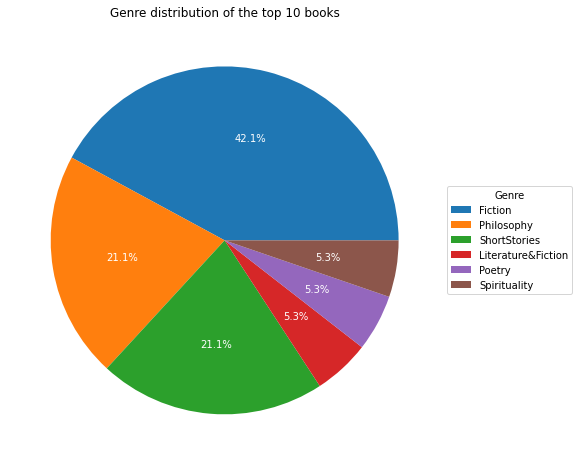

In [ ]:
from collections import Counter
genre_list=[]
for genre_group in list(df_top10.genre):
    genres = str.split(genre_group, ',')
    for genre in genres:
        genre = genre.replace(' ', '')
        genre_list.append(genre)
count = Counter(genre_list)
genre_df = pd.DataFrame.from_dict(count, orient='index')
genre_df = genre_df.reset_index()

genre_df.columns = ['genre', 'frequency']

fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct)


wedges, texts, autotexts = ax.pie(genre_df.frequency, autopct=lambda pct: func(pct, genre_df.frequency),
                                  textprops=dict(color="w"))

ax.legend(wedges, genre_df.genre,
          title="Genre",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

#plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Genre distribution of the top 10 books")

plt.show()

At which work age, the authors have the most editions of their works? In other words, when the authors wrote the most popular work pieces

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.histogram(df_clean, x = 'work_age', y = 'editions', color = 'author_name')
fig.show(renderer="colab")

Regarding the timeline, how popular the authors and their works from 1900 to 2010

In [ ]:
fig = px.histogram(df_clean, x = 'year', y = 'editions', color = 'author_name')
fig.show(renderer="colab")

Authors' work age and their works quality according to popularity and ratings

In [ ]:
fig = px.scatter(df_clean, x="work_age", y="avg_rating", color="author_name",
                 size='editions', hover_data=['ratings_count'])
fig.show(renderer="colab")

 ## 4.6 Correlation between columns:

In [ ]:
corr = df_clean.corr()
corr

,id,author_id,editions,year,avg_rating,ratings_count,text_reviews_count,birth_date,work_age
id,1.000000,-0.052046,-0.254135,0.251614,0.068099,-0.202994,-0.231433,0.239985,0.144601
author_id,-0.052046,1.000000,-0.022025,0.033253,0.218219,0.023191,0.030915,-0.004449,0.123749
editions,-0.254135,-0.022025,1.000000,-0.186859,-0.066744,0.060760,0.124168,-0.191517,-0.068918
year,0.251614,0.033253,-0.186859,1.000000,0.611110,0.277464,0.305090,0.958250,0.561760
avg_rating,0.068099,0.218219,-0.066744,0.611110,1.000000,0.290358,0.271471,0.623118,0.234732
ratings_count,-0.202994,0.023191,0.060760,0.277464,0.290358,1.000000,0.974624,0.330777,-0.031901
text_reviews_count,-0.231433,0.030915,0.124168,0.305090,0.271471,0.974624,1.000000,0.352373,-0.002274
birth_date,0.239985,-0.004449,-0.191517,0.958250,0.623118,0.330777,0.352373,1.000000,0.301755
work_age,0.144601,0.123749,-0.068918,0.561760,0.234732,-0.031901,-0.002274,0.301755,1.000000


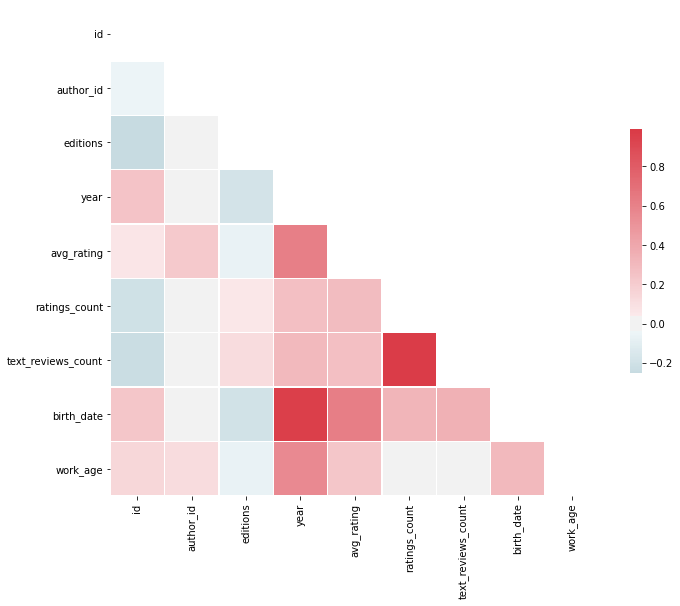

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Observations: There are some noticeable strong positive correlations:\
  . text_reviews_count and rating_counts\
  . avg_rating and year\
  . avg_rating and birht_date\
  . birth_date and year\
  . bith_date and avg_rating\
  . work_age and year\
  . editions and text_reviews_count


## 4.7 Book recommendations according to published year

In [ ]:
years = df_clean.year.to_list()
def books(year):
    df1 = df_clean[['avg_rating','title','year']]
    if year in years:
        df1 = df1[df1['year'] == year]
        print ('Recommended books for this year: ', df1[df1['avg_rating']>=3.5]['title'])
    else: print('There is no good books with these authors in this year')

In [ ]:
books(2017)

Recommended books for this year:  69    The Hogwarts Collection (Pottermore Presents, ...
Name: title, dtype: object


In [ ]:
books(2010)

There is no good books with these authors in this year
